In [1]:
import collections
import sys
sys.path.append("..")

import pandas as pd
import tqdm
import numpy as np
from IPython.display import SVG, HTML
from matplotlib import pyplot as plt
import tszip

import sc2ts
base_sc2_time = "2021-06-30"  # equivalent of day 0 in the sc2_ts file
sc2_ts = tszip.decompress(f"../results/upgma-full-md-30-mm-3-{base_sc2_time}-recinfo-il.ts.tsz")

base_sc2_time = "2022-06-30"  # equivalent of day 0 in the sc2_ts file
sc2_ts = tszip.decompress(f"../results/upgma-mds-1000-md-30-mm-3-{base_sc2_time}-recinfo-il.ts.tsz")


In [174]:
import collections
import numpy as np
import tskit

MRCA_data = collections.namedtuple(
    "MRCA_data", "mrca_id, node_count, mutation_count")

Mutation_data = collections.namedtuple(
    "Mutation_data", "num_mutations, num_reversions")

def mutations_per_edge(ts):
    # return the total number of mutations and revertant mutations above each edge
    ret = np.zeros((ts.num_edges, 2), int)
    for m in tqdm.tqdm(ts.mutations(), total=ts.num_mutations, desc="Count muts"):
        ret[m.edge, 0] += 1
        if m.parent != tskit.NULL:
            parent_mutation = ts.mutation(m.parent)
            if parent_mutation.parent == tskit.NULL:
                prev_prev_state = ts.site(parent_mutation.site).ancestral_state
            else:
                prev_prev_state = ts.mutation(parent_mutation.parent).derived_state
            if prev_prev_state == m.derived_state:
                ret[m.edge, 1] += 1
    return ret

def node_num_children(ts, node_list):
    # this is horribly slow: we shouldn't need to iterate over all the recombinant nodes in the trees
    node_children = collections.defaultdict(set)
    for tree in tqdm.tqdm(ts.trees(sample_lists=True)):
        for n in node_list:
            node_children[n] |= {s for s in tree.samples(n)}
    return {k: len(v) for k, v in node_children.items()}

def find_parents_mrca(ts, node_id, breakpoint, mutations_per_edge=None):
    """
    Track the parental lineage to the left of the breakpoint and to the right
    of the breakpoint for a given node and find the mrca of those two lineages
    (if any). Return the MRCA node ID, and the number of nodes passed through.
    If a mutations_per_edge mapping is given, also return the number of mutations
    passed through.
    """
    node_count = 0
    mutation_count = None if mutations_per_edge is None else np.zeros(2, int)
    node_times = ts.nodes_time
    tree1 = ts.at(np.nextafter(breakpoint, -np.inf))
    tree2 = ts.at(np.nextafter(breakpoint, np.inf))
    nd1 = node_id
    nd2 = node_id
    while True:
        if nd1 == tskit.NULL or nd2 == tskit.NULL:
            return MRCA_data(tskit.NULL, node_count, mutation_count)
        if node_times[nd1] == node_times[nd2]:
            if nd1 != node_id and nd1 == nd2:
                return MRCA_data(nd1, node_count, mutation_count)
            else:
                if tree1.parent(nd1) < tree2.parent(nd2):
                    if mutations_per_edge is not None:
                        mutation_count += mutations_per_edge[tree1.edge(nd1), :]
                    nd1 = tree1.parent(nd1)
                else:
                    if mutations_per_edge is not None:
                        mutation_count += mutations_per_edge[tree2.edge(nd2), :]
                    nd2 = tree2.parent(nd2)
                node_count += 1
                    
        elif node_times[nd1] < node_times[nd2]:
            if mutations_per_edge is not None:
                mutation_count += mutations_per_edge[tree1.edge(nd1), :]
            nd1 = tree1.parent(nd1)
            node_count += 1
        elif node_times[nd2] < node_times[nd1]:
            if mutations_per_edge is not None:
                mutation_count += mutations_per_edge[tree2.edge(nd2), :]
            nd2 = tree2.parent(nd2)
            node_count += 1

In [178]:
edge_mutations = mutations_per_edge(sc2_ts)

Count muts: 100%|██████████| 1062072/1062072 [02:15<00:00, 7810.38it/s] 


In [211]:
def collect_data(ts, edge_mutations=None):
    Data = collections.namedtuple(
        "Data",
        "d_nodes, d_time, d_mut, d_rev, mutations, mismatches, child_reversions, max_desc_children, parent_recomb")
    data = {}
    max_desc_children = sc2ts.max_descendant_samples(sc2_ts)
    recombinants = np.where(
        np.bitwise_and(ts.nodes_flags, sc2ts.NODE_IS_RECOMBINANT))[0]
    for u in tqdm.tqdm(recombinants, desc="Count recombinants"):
        n = ts.node(u)
        d_nodes = []
        d_time = []
        d_mut = []
        d_rev = []
        mutations = []
        mismatches = []
        parent_recomb = []
        mi = {i['direction']:i for i in n.metadata['match_info']}
        for direction in ('forward', 'backward'):
            assert mi[direction]['breakpoints'][0] == 0 and mi[direction]['breakpoints'][-1] == sc2_ts.sequence_length
            breakpoints = mi[direction]['breakpoints'][1:-1]
            for i, b in enumerate(breakpoints):
                if direction == "forward":
                    d = find_parents_mrca(ts, u, b, edge_mutations)
                    assert d.mrca_id != tskit.NULL
                    d_nodes.append(d.node_count)
                    d_time.append((ts.node(d.mrca_id).time - n.time) * 2)
                    d_mut.append(d.mutation_count[0])
                    d_rev.append(d.mutation_count[1])
            parents = mi[direction]['parents']
            parent_recomb.append(sum([(1 if (ts.node(v).flags & sc2ts.NODE_IS_RECOMBINANT) else 0) for v in parents]))
            mutations.append(len(mi[direction]['mutations']))
            mismatches.append(mi[direction]['num_mismatches'])
        child_reversions = np.sum(edge_mutations[ts.edges_parent == u, [False, True]])
        
        data[u] = Data(
            np.mean(d_nodes),
            np.mean(d_time),
            np.mean(d_mut),
            np.mean(d_rev),
            np.mean(mutations),
            np.mean(mismatches),
            child_reversions,
            max_desc_children[u],
            np.mean(parent_recomb),
        )
    return data

In [212]:
data = collect_data(sc2_ts, edge_mutations)

Count recombinants: 100%|██████████| 2078/2078 [05:13<00:00,  6.62it/s]


In [73]:
ti = sc2ts.TreeInfo(sc2_ts)

Classifying mutations: 100%|██████████| 1062072/1062072 [00:13<00:00, 76753.83it/s]


In [213]:
df_pr = ti.pango_recombinant_lineages_report()
pango_x_samples = []
for lin in set(df_pr.pango):
    pango_x_samples.extend(ti.pango_lineage_samples[lin])
df_ps = ti.recombinant_samples_report(pango_x_samples)
import collections
import pandas as pd

lin_recombs = collections.defaultdict(set)
recomb_lineages = collections.defaultdict(set)
for _, row in df_ps.iterrows():
    
    lin_recombs[row.pango].add(row.recombinant)
    recomb_lineages[row.recombinant].add(row.pango)
del lin_recombs["XP"]


data_summary = []
for lin, recombs in lin_recombs.items():
    data_summary.append(
        {"pango": lin, "samples": len(df_ps[df_ps.pango == lin]), 
         "num_recombinants": len(recombs), "recombinants": frozenset(recombs)})

df_summary = pd.DataFrame(data_summary)
df_summary.set_index("pango", inplace=True)
df_summary

samples  num_recombinants  \
pango                              
XC           5                 4   
XAD          6                 3   
XM          48                 5   
XQ          14                 5   
XAJ         12                 6   
XB          58                 3   
XAC         27                 1   
XL          10                 1   
XA           5                 1   
XV           3                 3   
XAE          9                 1   
XAA          8                 1   
XAH         14                 4   
XH          11                 1   
XW          11                 1   
XR           8                 1   
XAK          1                 1   
XY           6                 1   
XN          69                 8   
XJ           3                 3   
XE         170                12   
XD           4                 2   
XT           1                 1   
XF           2                 1   
XK           6                 4   
XAB         50                10   
XS           6                 3   
XG          32                 1   
XAF         36                 3   
XZ          92                16   
XAG         17                 1   
XU           3                 3   

                                            recombinants  
pango                                                     
XC                      (251176, 322219, 363172, 292030)  
XAD                             (649001, 641595, 555388)  
XM              (642277, 711560, 625355, 733196, 640831)  
XQ              (639472, 696838, 666230, 635896, 739545)  
XAJ     (722544, 745522, 749460, 774725, 731513, 555388)  
XB                              (206466, 394059, 285181)  
XAC                                             (682411)  
XL                                              (638141)  
XA                                              (172374)  
XV                              (752475, 638733, 630214)  
XAE                                             (701181)  
XAA                                             (635896)  
XAH                     (729963, 674321, 641595, 555388)  
XH                                              (582054)  
XW                                              (663539)  
XR                                              (639472)  
XAK                                             (555388)  
XY                                              (677584)  
XN     (615119, 731665, 703379, 555388, 677977, 67433...  
XJ                              (741659, 701594, 625355)  
XE     (582054, 687046, 749143, 729195, 699692, 75646...  
XD                                      (573905, 638775)  
XT                                              (637876)  
XF                                              (588841)  
XK                      (751632, 676545, 653674, 630235)  
XAB    (738307, 733742, 609881, 639472, 699376, 66309...  
XS                              (676648, 589269, 636566)  
XG                                              (609881)  
XAF                             (677584, 611036, 582054)  
XZ     (697157, 704521, 651744, 636903, 693927, 75684...  
XAG                                             (635896)  
XU                              (635896, 638141, 696838)

In [217]:
pango_names = {u: row.Index for row in df_summary.itertuples() for u in row.recombinants}
pango_map = {row.Index: next(iter(row.recombinants)) for row in df_summary.itertuples() if len(row.recombinants) == 1}

In [218]:
pango_intersect_names = {k: v for k, v in pango_names.items() if k in data}

In [255]:
import pandas as pd
import seaborn as sns
single_origin = {"XA", "XAC", "XAE", "XAK", "XF", "XG", "XH", "XL", "XR", "XT", "XW", "XY"}
df = pd.DataFrame(data.values(), index=data.keys())
df['pango_recombinant'] = np.where(np.isin(df.index, [next(iter(df_summary.loc[name].recombinants)) for name in single_origin]), 1, 0)

#df['pango_recombinant'] = [(1 if i in xx else 0) for i in df.index]
classifier = (
    (df['child_reversions']<3) *
    (df['mutations']<=10) *
    (df['d_time'] / (df['d_mut'] - df['d_rev']) < 10) *
    (df['max_desc_children'] > 0) *
    (df['parent_recomb'] == 0)
)
classifier += 2 * np.where(np.isin(df.index, list(pango_names.keys())), 1, 0)

# classifier 0 = not classified as believable, not labelled as recombinant
# classifier 1 = classified as believable, not labelled as recombinant
# classifier 2 = not classified as believable, labelled as recombinant
# classifier 3 = classified as believable, labelled as recombinant

df['pango_recombinant'] = classifier
df.sort_values('pango_recombinant', inplace=True)  # put known pango recombinants at the end, so they appear on top
df['log_num_mutations'] = np.log(1+df['mutations'])
df['log_max_desc_children'] = np.log(1+df['max_desc_children'])
df['rel_d_mut'] = df['d_mut'] - df['d_rev']
df.drop(columns=["mutations", "mismatches", "max_desc_children"], inplace=True)

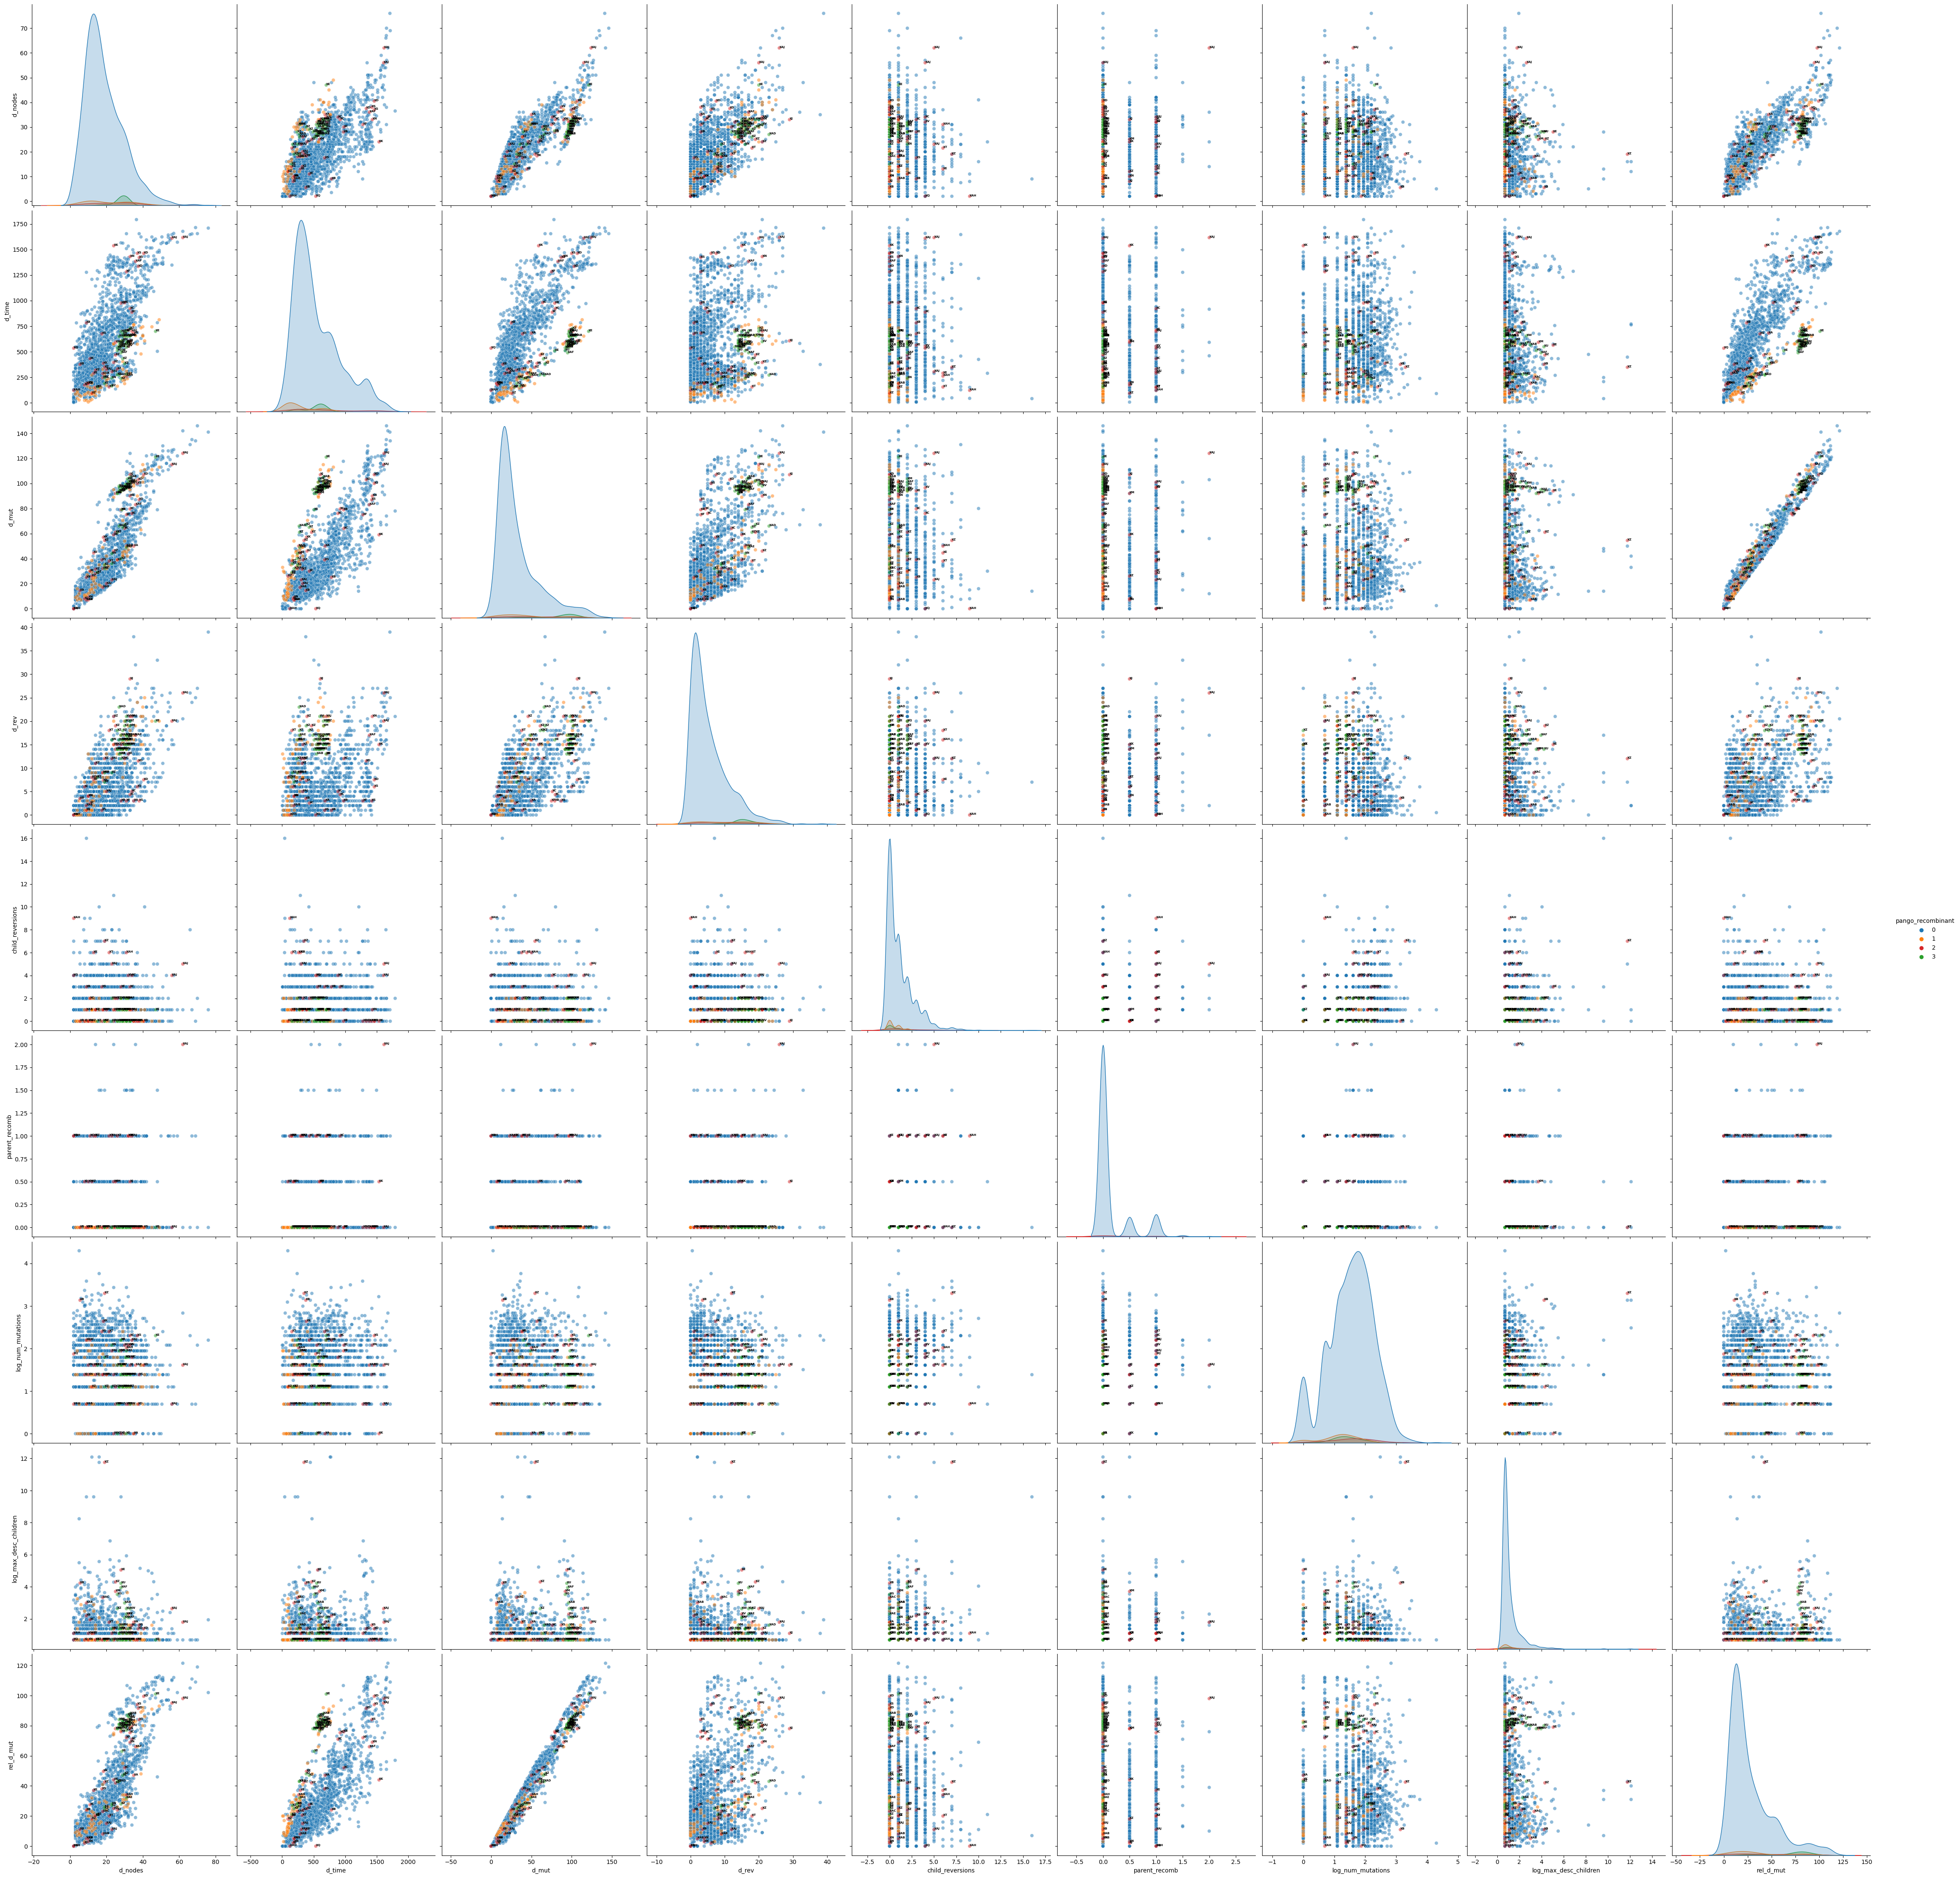

In [257]:
pp = sns.pairplot(df, hue="pango_recombinant", plot_kws={'alpha':0.5}, height=5, palette={0: "tab:blue", 1: "tab:orange", 2: "tab:red", 3: "tab:green"})
for ax in pp.axes.flat:
    for row in df.itertuples():
        if row.Index in set(pango_names.keys()):
            x = getattr(row, ax.get_xlabel(), None)
            y = getattr(row, ax.get_ylabel(), None)
            if x is not None and y is not None:
                ax.text(x, y, pango_names[row.Index], weight='bold', fontsize=5)
plt.savefig("pairplot.pdf")

In [59]:
def report(*args, **kwargs):
    display(*ti.node_report(*args, **kwargs))

In [84]:
sc2_ts.node(0)

Node(id=0, flags=0, time=918.0, population=-1, individual=-1, metadata={'Imputed_lineage': 'B', 'strain': 'Vestigial_ignore'})

In [66]:
sc2_ts.edges_parent

array([782228, 782916, 783046, ...,      1,      1,      0], dtype=int32)

In [93]:
xx = set()
recombinants = np.where(
        np.bitwise_and(sc2_ts.nodes_flags, sc2ts.NODE_IS_RECOMBINANT))[0]
for r in recombinants:
    children = np.unique(sc2_ts.edges_child[sc2_ts.edges_parent==r])
    for c in children:
        if (sc2_ts.node(c).metadata['Imputed_lineage'].startswith("X")):
            xx.add(r)
print(len(xx), len(recombinants))


79 2078


In [259]:
ii = df.loc[
    (df['child_reversions']<3) *
    (np.exp(df['log_num_mutations'])+1<=10) *
    (df['d_time'] / (df['d_mut'] - df['d_rev']) < 10) *
    (np.exp(df['log_max_desc_children'])+1 > 0) *
    (df['parent_recomb'] == 0)
].index

In [260]:
pango_known = {i for u in df_summary['recombinants'] for i in u}
ii, [i for i in ii if i not in pango_known]

(Int64Index([776159, 479081, 446196, 605514, 421732, 595382,  14596, 607526,
             249568, 587710,
             ...
             663539, 756841, 666230, 674229, 674332, 676531, 677584, 677977,
             731665, 663092],
            dtype='int64', length=107),
 [776159,
  479081,
  446196,
  605514,
  421732,
  595382,
  14596,
  607526,
  249568,
  587710,
  10617,
  588723,
  614135,
  408663,
  24138,
  759382,
  601876,
  758580,
  586250,
  608622,
  571086,
  418083,
  579471,
  566177,
  418533,
  85808,
  400888,
  762115,
  578814,
  400336,
  600927,
  387192,
  65540,
  6799,
  620528,
  745411,
  743460,
  293867,
  652247,
  339172,
  753750,
  659577,
  660632,
  661450,
  730277,
  662363,
  334567,
  666543,
  672305,
  716784,
  683290,
  200446,
  685963,
  316785,
  690263,
  539685,
  702325,
  728987,
  746426,
  657300,
  360810,
  156051,
  363579,
  623069,
  359896,
  358423,
  625645])

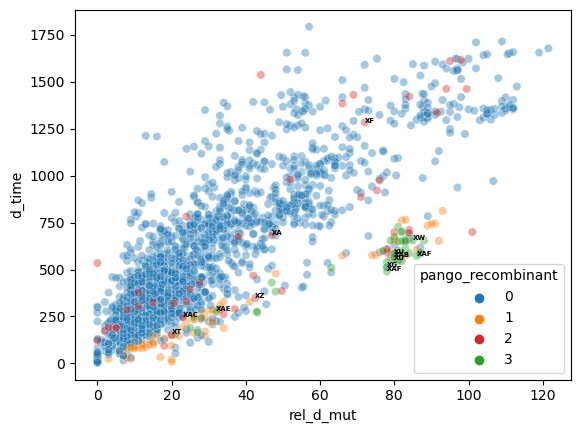

In [253]:
classifier = (
    (df['child_reversions']<3) *
    (np.exp(df['log_num_mutations'])+1<=10) *
    (df['d_time'] / (df['d_mut'] - df['d_rev']) < 10) *
    (np.exp(df['log_max_desc_children'])+1 > 0) *
    (df['parent_recomb'] == 0)
)
classifier += 2 * np.where(np.isin(df.index, list(pango_names.keys())), 1, 0)

# classifier 0 = not classified as believable, not labelled as recombinant
# classifier 1 = classified as believable, not labelled as recombinant
# classifier 2 = not classified as believable, labelled as recombinant
# classifier 3 = classified as believable, labelled as recombinant

df['pango_recombinant'] = classifier

ax = sns.scatterplot(df, x='rel_d_mut', y='d_time', alpha=0.4, hue='pango_recombinant', palette={0: "tab:blue", 1: "tab:orange", 2: "tab:red", 3: "tab:green"})
for row in df.itertuples():
    if row.Index in set(pango_map.values()):
        x = getattr(row, ax.get_xlabel(), None)
        y = getattr(row, ax.get_ylabel(), None)
        if x is not None and y is not None:
            ax.text(x, y, pango_names[row.Index], weight='bold', fontsize=5)


In [246]:
df.loc[660632]

d_nodes                   24.000000
d_time                   577.635000
d_mut                     95.000000
d_rev                     20.000000
child_reversions           2.000000
parent_recomb              0.000000
pango_recombinant          1.000000
log_num_mutations          1.791759
log_max_desc_children      1.386294
rel_d_mut                 75.000000
Name: 660632, dtype: float64

In [245]:
report(659577)

# Report for 659577

[{'Imputed_lineage': 'Recombinant',
  'date_added': '2022-03-16',
  'match_info': [{'breakpoints': [0, 22201, 29904],
    'direction': 'backward',
    'mutations': ['670G>T', '12880T>C', '15240C>T', '29510A>C'],
    'num_mismatches': 3.0,
    'parents': [641707, 622802],
    'strain': 'USA/MA-NEIDL-05306/2022'},
   {'breakpoints': [0, 22599, 29904],
    'direction': 'forward',
    'mutations': ['670G>T', '12880T>C', '15240C>T', '29510A>C'],
    'num_mismatches': 3.0,
    'parents': [641707, 622802],
    'strain': 'USA/MA-NEIDL-05306/2022'}]}]

### Node data 

node                     strain        pango  parents  children  \
0  659577           Added 2022-03-16  Recombinant        2         2   
1  641707       Overlap 1 mut 2 sibs         BA.2        1         3   
2  622802  USA/VA-CDC-LC0540454/2022       BA.1.1        1         1   

   descendants       date       delay    qc  mutations  reversions  \
0            3 2022-02-19 -19042 days  ----          0           0   
1            9 2022-02-10 -19033 days  ----          1           1   
2            2 2022-02-12     12 days  0000          1           1   

   immediate_reversions  child_mutations  child_reversions    role  \
0                     0                4                 2   Child   
1                     0                6                 2  Parent   
2                     0                0                 0  Parent   

   branch_length  
0            0.0  
1            8.9  
2            6.4

### Edges

### Copying pattern

## Left path to root

### Closest recombinant: 659577

node                             strain        pango  parents  children  \
0   659577                   Added 2022-03-16  Recombinant        2         2   
1   641707               Overlap 1 mut 2 sibs         BA.2        1         3   
2   619286  Belgium/ULB-IBC_CV8439842078/2022         BA.2        1        15   
3   559612                  Push 1 reversions         BA.2        1      2872   
4   581226               Overlap 1 mut 2 sibs         BA.2        1       195   
5   565478                  Push 2 reversions         BA.2        1        50   
6   568915                  Push 1 reversions         BA.2        1         8   
7   729474               Overlap 1 mut 2 sibs  Recombinant        1         2   
8   578988                  Push 4 reversions  Recombinant        1         8   
9   555388                   Added 2021-12-14  Recombinant        3         6   
10  544948          USA/NJ-GBW-EWR000001/2021         BA.3        1         2   
11  574542                  Push 2 reversions  Recombinant        1         3   
12  595533                  Push 1 reversions  Recombinant        1         3   
13  544949                   Added 2021-12-06  Recombinant        2         1   
14  519829               Overlap 1 mut 2 sibs        B.1.1        1         4   
15  240954          USA/CO-CDC-FG-019996/2021        B.1.1        1         1   
16  150642                  Push 1 reversions        B.1.1        1        16   
17    5867                   Added 2020-03-24        B.1.1        1      1396   
18    5868                   Added 2020-03-24          B.1        1        22   
19     179           Italy/LOM-ASST-CDG1/2020          B.1        1       512   
20      87          Germany/BY-ChVir-929/2020          B.1        1        13   
21    5174               Overlap 1 mut 2 sibs            B        1        13   
22    1876               Overlap 1 mut 2 sibs            B        1         7   
23       1                                               B        1       333   

    descendants       date       delay    qc  mutations  reversions  \
0             3 2022-02-19 -19042 days  ----          0           0   
1             9 2022-02-10 -19033 days  ----          1           1   
2            65 2022-02-09     16 days  0000          1           1   
3        125582 2021-12-14 -18975 days  ----          1           0   
4        126074 2021-12-14 -18975 days  ----          1           0   
5        127167 2021-12-14 -18975 days  ----          1           0   
6        127194 2021-12-14 -18975 days  ----          3           0   
7        127195 2021-12-14 -18975 days  ----          1           0   
8        127202 2021-12-14 -18975 days  ----         15           5   
9        127226 2021-12-12 -18973 days  ----          3           3   
10       127227 2021-12-06     16 days  1000          2           0   
11       127228 2021-12-06 -18967 days  ----          1           0   
12       127229 2021-12-06 -18967 days  ----         19           5   
13       127229 2021-12-05 -18966 days  ----          0           0   
14       193270 2021-04-25 -18742 days  ----          1           0   
15       193271 2021-04-02     19 days  0010          2           0   
16       193324 2020-05-22 -18404 days  ----          1           0   
17       271967 2020-02-22 -18314 days  ----          1           1   
18       465556 2020-02-21 -18313 days  ----          1           0   
19       651890 2020-02-20     10 days  0000          1           0   
20       651948 2020-01-28      3 days  0000          1           0   
21       651968 2020-01-20 -18281 days  ----          1           0   
22       651982 2020-01-12 -18273 days  ----          1           0   
23       657238 2019-12-26 -18256 days  ----          0           0   

    immediate_reversions  branch_length  
0                      0       8.900000  
1                      0       0.500000  
2                      0      57.300000  
3                      0       0.131

## Right path to root

### Closest recombinant: 659577

node                     strain        pango  parents  children  \
0   659577           Added 2022-03-16  Recombinant        2         2   
1   622802  USA/VA-CDC-LC0540454/2022       BA.1.1        1         1   
2   603330          Push 1 reversions       BA.1.1        1         4   
3   529477        Ghana/TRA-2288/2021       BA.1.1        1      2982   
4   537963       Overlap 1 mut 2 sibs       BA.1.1        1        78   
5   521046          Push 1 reversions         BA.1        1       153   
6   519279           Added 2021-11-16         BA.1        1       352   
7   581228       Overlap 1 mut 2 sibs         BA.1        1         2   
8   575715       Overlap 1 mut 2 sibs         BA.1        1         2   
9   519280           Added 2021-11-16         BA.1        1        34   
10  526290          Push 1 reversions         BA.1        1        30   
11  543137          Push 1 reversions        B.1.1        1         4   
12  568904          Push 4 reversions        B.1.1        1         3   
13  582335       Overlap 6 mut 2 sibs        B.1.1        1         3   
14  519829       Overlap 1 mut 2 sibs        B.1.1        1         4   
15  240954  USA/CO-CDC-FG-019996/2021        B.1.1        1         1   
16  150642          Push 1 reversions        B.1.1        1        16   
17    5867           Added 2020-03-24        B.1.1        1      1396   
18    5868           Added 2020-03-24          B.1        1        22   
19     179   Italy/LOM-ASST-CDG1/2020          B.1        1       512   
20      87  Germany/BY-ChVir-929/2020          B.1        1        13   
21    5174       Overlap 1 mut 2 sibs            B        1        13   
22    1876       Overlap 1 mut 2 sibs            B        1         7   
23       1                                       B        1       333   

    descendants       date       delay    qc  mutations  reversions  \
0             3 2022-02-19 -19042 days  ----          0           0   
1             2 2022-02-12     12 days  0000          1           1   
2             6 2022-01-03 -18995 days  ----          1           1   
3         31040 2021-11-24      7 days  0000          1           0   
4         34868 2021-11-15 -18946 days  ----          1           0   
5        182698 2021-11-05 -18936 days  ----          1           0   
6        192577 2021-08-17 -18856 days  ----          2           0   
7        192578 2021-07-25 -18833 days  ----          1           0   
8        192579 2021-07-03 -18811 days  ----          1           0   
9        192746 2021-05-18 -18765 days  ----          1           0   
10       192804 2021-05-15 -18762 days  ----          1           0   
11       192905 2021-05-13 -18760 days  ----          4           0   
12       192908 2021-05-11 -18758 days  ----         24           0   
13       192909 2021-05-03 -18750 days  ----          6           0   
14       193270 2021-04-25 -18742 days  ----          1           0   
15       193271 2021-04-02     19 days  0010          2           0   
16       193324 2020-05-22 -18404 days  ----          1           0   
17       271967 2020-02-22 -18314 days  ----          1           1   
18       465556 2020-02-21 -18313 days  ----          1           0   
19       651890 2020-02-20     10 days  0000          1           0   
20       651948 2020-01-28      3 days  0000          1           0   
21       651968 2020-01-20 -18281 days  ----          1           0   
22       651982 2020-01-12 -18273 days  ----          1           0   
23       657238 2019-12-26 -18256 days  ----          0           0   

    immediate_reversions  branch_length  
0                      0       6.400000  
1                      0      40.625000  
2                      0      39.375000  
3                      0       9.700000  
4                      0       9.700000  
5                      0      79.800000  
6                      0      22.800000  
7                      0      22.800000  
8                      0  

### Children 
Node 659577 has 2 children. Showing top-10 by descendant count

node                   strain        pango  parents  children  \
0  659576  USA/MA-NEIDL-05306/2022      BA.2.23        1         1   
1  705521         Added 2022-04-25  Recombinant        2         1   

   descendants       date       delay    qc  mutations  reversions  \
0            2 2022-03-16     20 days  0000          4           0   
1            0 2022-04-19 -19101 days  ----          0           0   

   immediate_reversions  child_mutations  child_reversions  new_muts  \
0                     0                0                 0         4   
1                     0                4                 2         0   

   same_site_muts  branch_length  
0               0          25.60  
1               0          59.52

## Mutation path

site    node  descendants  inheritors inherited_state derived_state  \
63  24503  622802            2           2               T             C   
10   9344  641707           10          10               T             C   
12   9424  619286           66          37               G             A   
59  24130  603330            6           6               A             C   
17  10198  559612       125330      125033               C             T   
..    ...     ...          ...         ...             ...           ...   
5    1191    5868       288217        4062               C             T   
25  14408     179       651885      651284               C             T   
7    3037      87       651936      651116               C             T   
53  23403    5174       651952      651680               A             G   
0     241    1876       651969      649632               C             T   

    is_reversion  is_immediate_reversion  is_transition  is_transversion  \
63          True                   False           True            False   
10          True                   False           True            False   
12          True                   False           True            False   
59          True                   False          False             True   
17         False                   False           True            False   
..           ...                     ...            ...              ...   
5          False                   False           True            False   
25         False                   False           True            False   
7          False                   False           True            False   
53         False                   False           True            False   
0          False                   False           True            False   

    is_insertion  is_deletion  parent  num_parents     time      id  \
63         False        False  762410            1  138.000  762462   
10         False        False  320839            1  140.500  320871   
12         False        False  322295            1  141.000  322310   
59         False        False  752244            1  178.625  752489   
17         False        False      -1            0  198.300  345119   
..           ...          ...     ...          ...      ...     ...   
5          False        False      -1            0  860.500   53094   
25         False        False      -1            0  861.000  461751   
7          False        False      -1            0  884.000  121305   
53         False        False      -1            0  892.250  724978   
0          False        False      -1            0  900.500   10961   

               metadata  
63                   {}  
10  {'type': 'overlap'}  
12                   {}  
59                   {}  
17                   {}  
..                  ...  
5                    {}  
25                   {}  
7                    {}  
53  {'type': 'overlap'}  
0   {'type': 'overlap'}  

[74 rows x 17 columns]